In [363]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

from os import listdir
from os.path import isfile, join

In [364]:
image = cv2.imread("1005_20UPGM23211816_AfterBonding.jpg")
image.shape

(5504, 6880, 3)

In [365]:
## Trouver la colonne verte à gauche

def find_column_left(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes):
        col=colonnes[i]
        for pix in col:
            if (pix[1]>50) and (pix[0]<30) and (pix[2]<30):
                bool=True
        if not bool:
            i+=1
    return i, colonnes[i]

In [366]:
# Même chose à droite

def find_column_right(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=image.shape[1]-1
    bool=False
    while not bool and i>=0:
        col=colonnes[i]
        for pix in col:
            if (pix[1]>50) and (pix[0]<30) and (pix[2]<30):
                bool=True
        if not bool:
            i-=1
    return i, colonnes[i]

In [367]:
# # Compte le nombre de fils du module

def count(image, column_left, column_right) :
    state = False
    levels = np.arange(0.6, 1.0, 0.01)
    counters = np.zeros(levels.shape[0])
    for j in range(levels.shape[0]) :
        for i in range(image.shape[0]) :
            if (image[i,column_left-5:column_left+5].sum()/(255*10*3)) > levels[j] :
                if not(state) :
                    counters[j]+=1
                    state = True
            else :
                state = False
    state = False
    unique, counts = np.unique(counters, return_counts=True)
    arg = np.argmax(counts)
    print(unique[arg])
    for j in range(levels.shape[0]) :
        for i in range(image.shape[0]) :
            if (image[i,column_right-5:column_right+5].sum()/(255*10*3)) > levels[j] :
                if not(state) :
                    counters[j]+=1
                    state = True
            else :
                state = False
    unique, counts = np.unique(counters, return_counts=True)
    arg = np.argmax(counts)
    return (unique[arg])

# # counters = count(image, column_left=777, column_right=6080)
# # plt.plot(np.arange(0.6, 1.0, 0.01), counters)

# print(count(image, column_left=777, column_right=6080))

In [368]:
image = cv2.imread("ModulePictures/P1018_20UPGM23211497_AfterWirebonding.jpg")
print(count(image, column_left=860, column_right=6070))

353.0
703.0


In [369]:
with open("iref_trim_per_module.json", "r") as f:
    data = json.load(f)

In [370]:
def iref_trim (serialNumber, data) :
    error = True
    for x in data :
        if x['serialNumber'] == serialNumber :
            iref = x
            error = False
    if error :
        return ("serialNumber not found")
    return (iref['IREF_TRIM_1'], iref['IREF_TRIM_2'], iref['IREF_TRIM_3'], iref['IREF_TRIM_4'])

In [371]:
iref_trim('20UPGM23210148', data)

(13, 11, 8, 6)

In [372]:
def extract_serial_number (file_name) :
    names = file_name.split("_")
    for x in names :
        if "20UPGM" in x :
            return (x)
    return (None)

In [373]:
extract_serial_number("1005_20UPGM23211816_AfterBonding")

'20UPGM23211816'

In [374]:
def expected_wire_number (serialNumber, data) :
    iref = iref_trim(serialNumber, data)
    nb_wire_per_trim = [4, 3, 3, 2, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 0]
    return (693 + nb_wire_per_trim[iref[0]] + nb_wire_per_trim[iref[1]] + nb_wire_per_trim[iref[2]] + nb_wire_per_trim[iref[3]])

In [375]:
serial = extract_serial_number("1005_20UPGM23211816_AfterBonding")
iref_trim(serial, data)

(8, 8, 9, 7)

In [376]:
expected_wire_number(serial, data)

702

In [377]:
serial = extract_serial_number("20UPGM23211355_PPPV2_46_AfterBonding")
iref_trim(serial, data)

(11, 9, 6, 10)

In [378]:
def test_wire_number (file_name, data, column_left = None, column_right = None) :
    expected_nb = expected_wire_number(extract_serial_number(file_name), data)
    print(expected_nb)
    image = cv2.imread("ModulePictures/" + file_name)
    if column_left == None :
        column_left = find_column_left(image)[0] - 200
    if column_right == None :
        column_right = find_column_right(image)[0] + 200
    real_nb = count(image, column_left, column_right)
    print(real_nb)
    return (expected_nb == real_nb)

In [379]:
test_wire_number('P1018_20UPGM23211497_AfterWirebonding.jpg', data, 880, 6080)

700
354.0
704.0


np.False_

In [380]:
# Test
fichiers = [f for f in listdir("ModulePictures") if isfile(join("ModulePictures", f))]
fichiersOK = []

for x in fichiers :
    if not("NOK" in x) and not("NoLight" in x) and not("AfterRebounding" in x) :
        fichiersOK.append(x)
        # test = test_wire_number(x, data)
        # print(test)
        # if not(test) :
        #     print(x)

In [381]:
fichiersOK

['20UPGM23211355_PPPV2_46_AfterBonding.jpg',
 'P1008_20UPGM23210595_AfterWirebonding.jpg',
 'P1014_20UPGM23211689_AfterWirebonding.jpg',
 'P1015_20UPGM23210321_AfterWirebonding.jpg',
 'P1017_20UPGM23211308_AfterWirebonding.jpg',
 'P1018_20UPGM23211497_AfterWirebonding.jpg',
 'P1023_20UPGM23211432_AfterWirebonding.jpg',
 'P1024_20UPGM23211820_AfterWirebonding.jpg',
 'P1027_20UPGM23211441_AfterBonding.jpg',
 'P1033_20UPGM23211444_AfterBonding.jpg']

In [382]:
# print(test_wire_number('20UPGM23211355_PPPV2_46_AfterBonding.jpg', data, 800, 6080))
# OK

# print(test_wire_number('P1008_20UPGM23210595_AfterWirebonding.jpg', data, 820, 6030))
# OK

# print(test_wire_number('P1014_20UPGM23211689_AfterWirebonding.jpg', data, 870, 6080))
# OK

# print(test_wire_number('P1015_20UPGM23210321_AfterWirebonding.jpg', data, 840, 6050))
# OK

# print(test_wire_number('P1017_20UPGM23211308_AfterWirebonding.jpg', data, 880, 6080))
# OK

# print(test_wire_number('P1018_20UPGM23211497_AfterWirebonding.jpg', data, 860, 6070))
# Pb : 703 au lieu de 700

# print(test_wire_number('P1023_20UPGM23211432_AfterWirebonding.jpg', data, 940, 6160))
# Pb : 705 au lieu de 698

# print(test_wire_number('P1024_20UPGM23211820_AfterWirebonding.jpg', data, 930, 6160))
# Pb : 704 au lieu de 700

# print(test_wire_number('P1027_20UPGM23211441_AfterBonding.jpg', data, 800, 6030))
# Pb : 701 au lieu de 697

# print(test_wire_number('P1033_20UPGM23211444_AfterBonding.jpg', data, 860, 6110))
# Pb : 704 au lieu de 700

In [383]:
print(iref_trim('20UPGM23211497', data))

(12, 12, 7, 10)


In [384]:
print(count(image, column_left=860, column_right=6070))
# Attendu : 352 / 700

353.0
703.0


In [385]:
def crop_lignes (image) :
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bw = cv2.threshold(grey, 127,255,cv2.THRESH_BINARY_INV)[1]
    n = bw.shape[0]
    limit_high = 0
    x = bw[limit_high].mean()
    while (limit_high < n//2) and (x <= 150) :
        limit_high+=1
        x = bw[limit_high].mean()
    limit_low = n-1
    x = bw[limit_low].mean()
    while (limit_low > n//2) and (x <= 150) :
        limit_low-=1
        x = bw[limit_low].mean()
    return (limit_high, limit_low)

In [386]:
def crop_colonnes (image) :
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bw = cv2.threshold(grey, 127,255,cv2.THRESH_BINARY_INV)[1]
    n = bw.shape[1]
    limit_left = 0
    x = bw[:,limit_left].mean()
    while (limit_left < n//2) and (x <= 150) :
        limit_left+=1
        x = bw[:,limit_left].mean()
    limit_right = n-1
    x = bw[:,limit_right].mean()
    while (limit_right > n//2) and (x <= 150) :
        limit_right-=1
        x = bw[:,limit_right].mean()
    return (limit_left, limit_right)

In [398]:
def crop_test_wire_number (file_name, data) :
    expected_nb = expected_wire_number(extract_serial_number(file_name), data)
    print(expected_nb)
    image = cv2.imread("ModulePictures/" + file_name)
    high, low = crop_lignes(image)
    left, right = crop_colonnes(image)
    image_crop = image[high:low, left:right]
    if (image_crop.shape[1] < 5700) :
        real_nb = count(image_crop, column_left = 100 , column_right = image_crop.shape[1]-100)
    else :
        real_nb = count(image_crop, column_left = 500 , column_right = image_crop.shape[1]-500)
    print(real_nb)
    return (expected_nb == real_nb)

In [399]:
# test

# print(crop_test_wire_number('20UPGM23211355_PPPV2_46_AfterBonding.jpg', data))
# 6221 colonnes
# OK avec +/- 500

# print(crop_test_wire_number('P1008_20UPGM23210595_AfterWirebonding.jpg', data))
# 5393 colonnes
# OK avec +/- 100

# print(crop_test_wire_number('P1014_20UPGM23211689_AfterWirebonding.jpg', data))
# 5389 colonnes
# OK avec +/- 100

# print(crop_test_wire_number('P1015_20UPGM23210321_AfterWirebonding.jpg', data))
# 5390 colonnes
# OK avec +/- 100

# print(crop_test_wire_number('P1017_20UPGM23211308_AfterWirebonding.jpg', data))
# 5378 colonnes
# OK avec +/- 100

print(crop_test_wire_number('P1018_20UPGM23211497_AfterWirebonding.jpg', data))
# Pb : 698 au lieu de 700

print(crop_test_wire_number('P1023_20UPGM23211432_AfterWirebonding.jpg', data))
# Pb : 699 au lieu de 698

print(crop_test_wire_number('P1024_20UPGM23211820_AfterWirebonding.jpg', data))
# Pb :

print(crop_test_wire_number('P1027_20UPGM23211441_AfterBonding.jpg', data))
# Pb :

print(crop_test_wire_number('P1033_20UPGM23211444_AfterBonding.jpg', data))
# 5054 colonnes
# OK avec +/- 100

700
348.0
698.0
False
698
351.0
699.0
False
700
350.0
696.0
False
697
345.0
693.0
False
700
350.0
699.0
False


In [389]:
print(iref_trim('20UPGM23211497', data))

(12, 12, 7, 10)


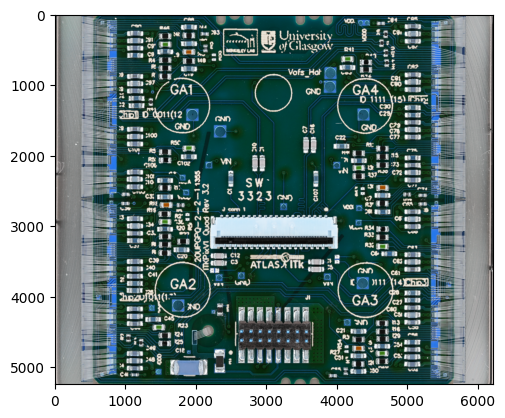

In [390]:
image = cv2.imread('ModulePictures/20UPGM23211355_PPPV2_46_AfterBonding.jpg')
high, low = crop_lignes(image)
left, right = crop_colonnes(image)
image_crop = image[high:low, left:right]
plt.imshow(image_crop)

In [391]:
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
bw = cv2.threshold(grey, 127,255,cv2.THRESH_BINARY_INV)[1]

lignes = np.zeros(bw.shape[0])
colonnes = np.zeros(bw.shape[1])

for i in range (bw.shape[0]) :
    lignes[i] = bw[i].mean()

for j in range (bw.shape[1]) :
    colonnes[j] = bw[:,j].mean()

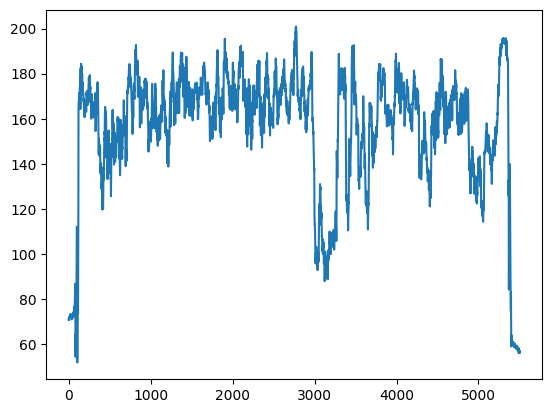

In [392]:
plt.plot(np.arange(bw.shape[0]), lignes)

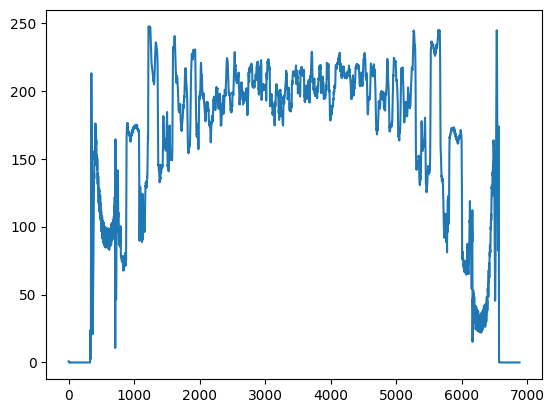

In [393]:
plt.plot(np.arange(bw.shape[1]), colonnes)